In [17]:
import numpy as np
import tensorflow  as tf
import matplotlib.pyplot as plt
import os
import torch
from matplotlib import cm

In [18]:
import warnings

warnings.filterwarnings('ignore')

In [19]:
def plot_acc(history):

    # Accuracy
    plt.figure()
    plt.plot(
        history.history['accuracy'],
        label='Accuracy',
        marker='o',
        color = 'green'
    )
    plt.plot(
        history.history['val_accuracy'],
        label='Validation Accuracy',
        marker='o',
        color = 'red'
    )
    plt.title('Accuracy of model on each data')
    plt.xlabel('Epochs')
    plt.ylabel('%',rotation=0)
    plt.legend()
    plt.grid()

    # Loss
    plt.figure()
    plt.plot(
        history.history['loss'],
        label='Loss',
        marker='o',
        color = 'green'
    )
    plt.plot(
        history.history['val_loss'],
        label='Validation Loss',
        marker='o',
        color = 'red'
    )
    plt.title('Loss of model on each data')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()


## TensorFlow

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [21]:
print(f'There is total {x_train.shape[0]} images for train and {x_test.shape[0]} for test',end='\n\n')
print(f'The size of each image is {x_train.shape[1:]} for both train and test input data', end='\n\n')
print(f'Train output has  the shape of {y_train.shape} and the test output has the shape of {y_test.shape}')

There is total 60000 images for train and 10000 for test

The size of each image is (28, 28) for both train and test input data

Train output has  the shape of (60000,) and the test output has the shape of (10000,)


Displaying an example of each class

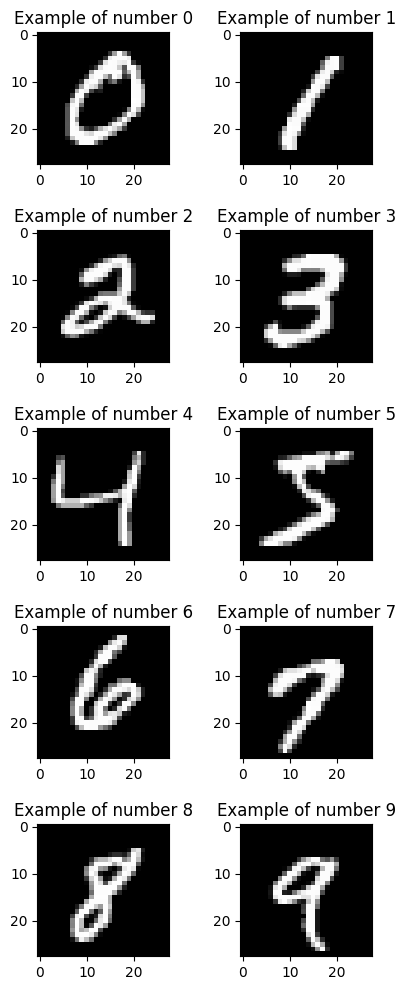

In [22]:
plt.figure(figsize=(5,12))
for i in range(10):

    image = x_train[y_train==i][0]
    plt.subplot(5,2,i+1)
    plt.imshow(image,cmap='gray')
    plt.title(f'Example of number {i}')
    plt.subplots_adjust(hspace=0.5, wspace=0.1)


Plotting the histogram

Text(0.5, 0, 'Classes')

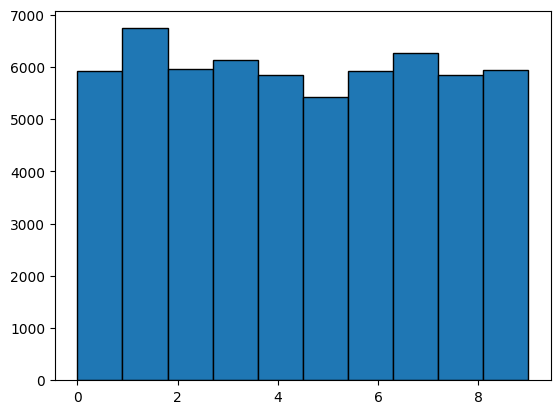

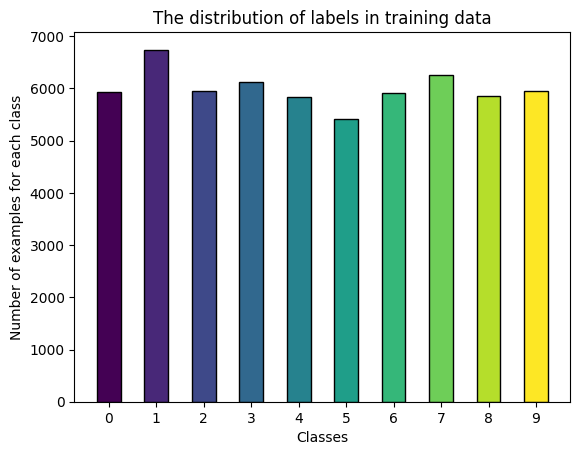

In [23]:
hist, bins = np.histogram(y_train,bins=10)
cmap = cm.get_cmap('viridis')

# With histogram
plt.figure()
plt.hist(y_train,bins=bins,edgecolor='black')

# With barplot
plt.figure()
bins = np.arange(0,10,1) # This is to correct the bins
plt.bar(bins, hist, width=0.5,edgecolor='black',color=cmap(np.linspace(0, 1, len(hist))))
plt.xticks(range(len(hist)), range(10))
plt.title('The distribution of labels in training data')
plt.ylabel('Number of examples for each class')
plt.xlabel('Classes')

Normalizing the data

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the data (The shape must be adjusted for the MinMaxScaler to work)
scaler = MinMaxScaler()
scaler.fit(x_train.reshape(-1,28*28)) # Creaing the parameters
x_train_scaled = scaler.fit_transform(x_train.reshape(-1,28*28))
x_test_scaled = scaler.fit_transform(x_test.reshape(-1,28*28))

# Reshaping the scaled data to the original form
x_train_scaled = x_train_scaled.reshape(-1,28,28)
x_test_scaled = x_test_scaled.reshape(-1,28,28)

# Printing the difference
print(f'The max of "x_train" is {np.max(x_train)} and the max of "x_train_scaled" is {np.max(x_train_scaled)}',end='\n\n')
print(f'The max of "x_test" is {np.max(x_test)} and the max of "x_test_scaled" is {np.max(x_test_scaled)}',end='\n\n')

The max of "x_train" is 255 and the max of "x_train_scaled" is 1.0

The max of "x_test" is 255 and the max of "x_test_scaled" is 1.0



### Teacher's network

Creating the model

In [25]:
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.models import Model

In [26]:
teacher = tf.keras.models.Sequential(
    [
        Input(shape=(28,28,)),
        Flatten(),
        Dense(1024,activation='relu'),
        Dense(512, activation='relu'),
        Dense(10, activation='linear')
    ]
    )
teacher.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 1024)              803840    
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1333770 (5.09 MB)
Trainable params: 1333770 (5.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training the model


In the context of machine learning, particularly in neural networks and deep learning, the term "**logits**" refers to the *raw*, *unnormalized predictions* generated by a model **before applying an activation function or a probability distribution.**

In [27]:
teacher.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# Because there was no softmax we should set the from_logits  to True
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics = 'accuracy'
    )

t_history = teacher.fit(
    x = x_train_scaled,
    y = y_train,
    epochs =20,
    batch_size = 32,
    validation_data = (x_test_scaled,y_test)
    )

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.5310 - accuracy: 0.8686 - val_loss: 0.2906 - val_accuracy: 0.9198
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2593 - accuracy: 0.9270 - val_loss: 0.2295 - val_accuracy: 0.9329
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2094 - accuracy: 0.9407 - val_loss: 0.1883 - val_accuracy: 0.9460
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1766 - accuracy: 0.9506 - val_loss: 0.1640 - val_accuracy: 0.9512
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1525 - accuracy: 0.9568 - val_loss: 0.1442 - val_accuracy: 0.9584
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1336 - accuracy: 0.9625 - val_loss: 0.1322 - val_accuracy: 0.9603
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1186 - accuracy: 0.9670 - val_loss: 0.1209 - val_accuracy:

Plotting the accuracy of the model for each epoch

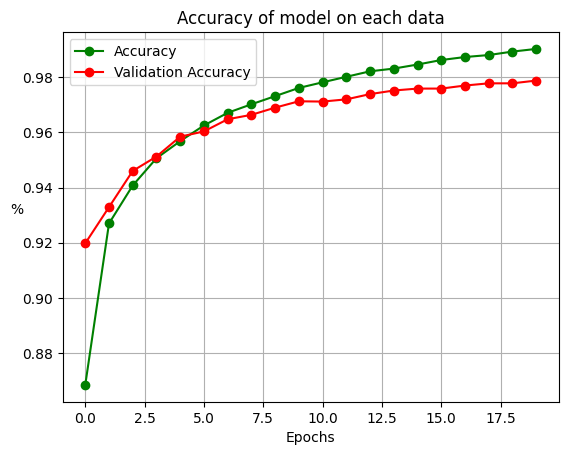

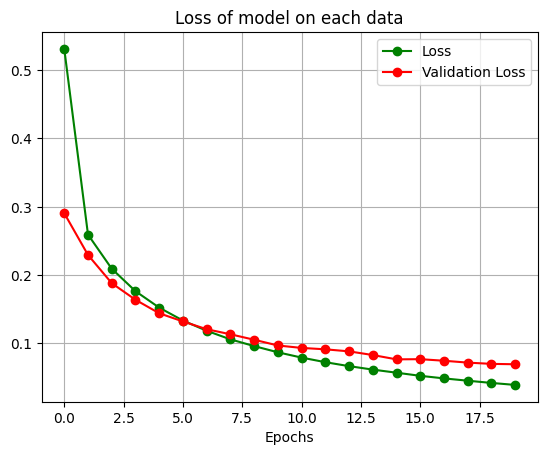

In [28]:
plot_acc(t_history)

In [29]:
y_test_hat = teacher.predict(x_test_scaled)

313/313 [==============================] - 1s 2ms/step


In [30]:
y_test_hat_arg = np.argmax(y_test_hat,axis=1)
miss_class_test = np.sum(np.array(y_test_hat_arg != y_test))
print(f'There are {miss_class_test} miscalssified test examples from total of {len(y_test)} test examples')

There are 213 miscalssified test examples from total of 10000 test examples


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat_arg))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### Student's network

In [32]:
student = tf.keras.models.Sequential(
    [
        Input(shape=(28,28,)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='relu')
    ],
    name = 'student'
)
student.summary()
student_2 = tf.keras.models.clone_model(student)

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
student.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# Because there was no softmax we should set the from_logits  to True
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics = 'accuracy'
)

In [34]:
s_history = student.fit(
    x = x_train_scaled,
    y = y_train,
    epochs = 10,
    batch_size = 32,
    validation_data = (x_test_scaled, y_test)
)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.8808 - accuracy: 0.7510 - val_loss: 0.5468 - val_accuracy: 0.8271
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5187 - accuracy: 0.8327 - val_loss: 0.4813 - val_accuracy: 0.8401
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4676 - accuracy: 0.8445 - val_loss: 0.4453 - val_accuracy: 0.8485
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3487 - accuracy: 0.8880 - val_loss: 0.2125 - val_accuracy: 0.9411
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2014 - accuracy: 0.9440 - val_loss: 0.1847 - val_accuracy: 0.9456
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1764 - accuracy: 0.9504 - val_loss: 0.1681 - val_accuracy: 0.9504
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1578 - accuracy: 0.9556 - val_loss: 0.1534 - val_accuracy:

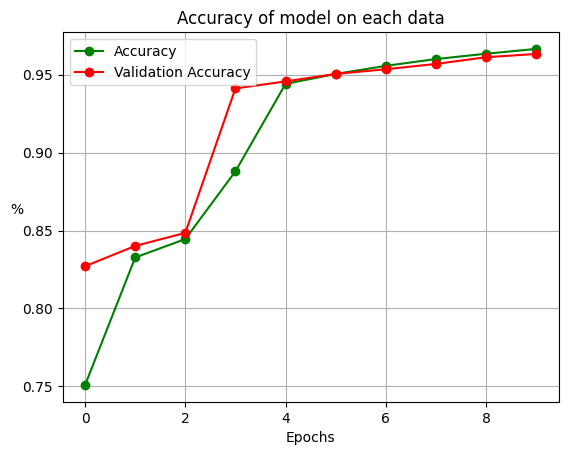

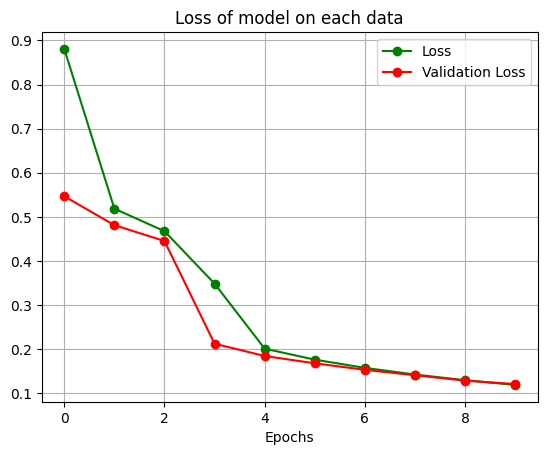

In [35]:
plot_acc(s_history)

### Knowledge Distillation

In [36]:
t_logits_train = teacher.predict(x_train_scaled)
t_logits_test = teacher.predict(x_test_scaled)

313/313 [==============================] - 0s 2ms/step


In [37]:
student_2 = tf.keras.models.Sequential(
    [
        Input(shape=(28,28,)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='relu')
    ],
    name = 'student'
)

In [38]:
student_2.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics = 'accuracy'
)

In [39]:
s2_history = student_2.fit(
    x = x_train_scaled,
    y = t_logits_train,
    epochs = 10,
    batch_size = 32,
    validation_data = (x_test_scaled, t_logits_test)
)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 14.6775 - accuracy: 0.7574 - val_loss: 13.1289 - val_accuracy: 0.8433
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 12.5206 - accuracy: 0.8505 - val_loss: 12.7699 - val_accuracy: 0.8625
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 12.3242 - accuracy: 0.8619 - val_loss: 12.6959 - val_accuracy: 0.8680
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 12.2560 - accuracy: 0.8671 - val_loss: 12.6393 - val_accuracy: 0.8719
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 12.2217 - accuracy: 0.8693 - val_loss: 12.6195 - val_accuracy: 0.8726
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 12.2010 - accuracy: 0.8709 - val_loss: 12.6030 - val_accuracy: 0.8739
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 12.1862 - accuracy: 0.8722 - val_loss: 12.5907 -

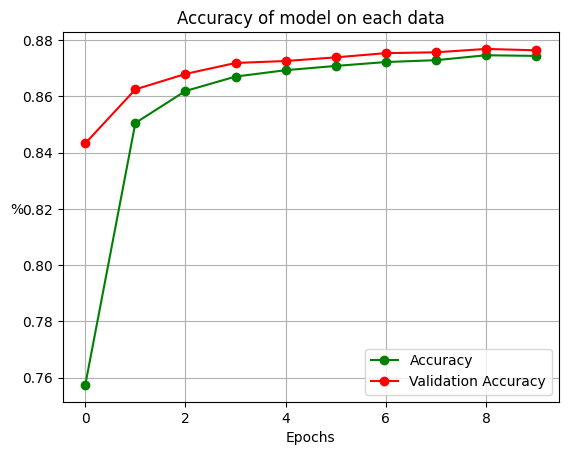

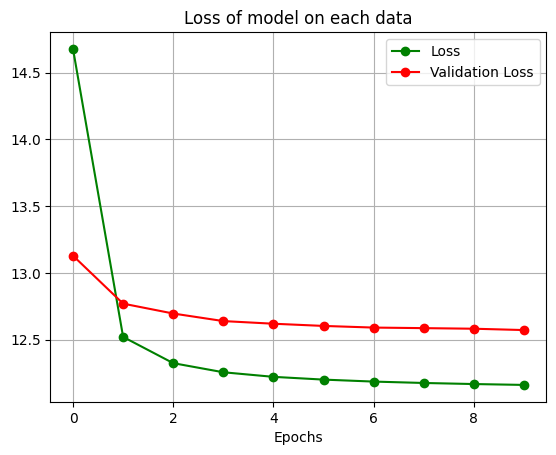

In [40]:
plot_acc(s2_history)

In [41]:
yhat_1 = student.predict(x_test_scaled)
yhat_2 = student_2.predict(x_test_scaled)

313/313 [==============================] - 1s 2ms/step


In [42]:
yhat_1_arg = np.argmax(yhat_1,axis=1)
yhat_2_arg = np.argmax(yhat_2,axis=1)
missclass_1 = np.sum(np.array(yhat_1_arg != y_test))
missclass_2 = np.sum(np.array(yhat_2_arg != y_test))
print(f'student model has {missclass_1} miss-classified examples\nstudent_2 model has {missclass_2} miss-classified examples')

student model has 368 miss-classified examples
student_2 model has 1381 miss-classified examples


In [67]:
from sklearn.metrics import classification_report
print('The student performance')
print(classification_report(y_test, yhat_1_arg))
print('Knowledge distilation performance')
print(classification_report(np.argmax(t_logits_test,axis=1),np.argmax(yhat_2,axis=1)))

The student performance
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.97      0.96      0.97      1010
           4       0.96      0.97      0.96       982
           5       0.96      0.95      0.96       892
           6       0.96      0.97      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.96      0.95       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Knowledge distilation performance
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       987
           1       0.00      0.00      0.00      1138
           2       0

In [66]:
print(np.argmax(t_logits_test,axis=1))
print(np.argmax(yhat_2,axis=1))

[7 2 1 ... 4 5 6]
[7 2 7 ... 4 5 6]


#### The other  method

I found this mehtod that had differecnt math than what was
required in the exercise

## Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
# Path of folders
mnist_dir = '/content/MNIST'
train_dir = os.path.join(mnist_dir,'train')
test_dir = os.path.join(mnist_dir,'test')

# making paths
if not os.path.isdir(mnist_dir):
    os.makedirs(train_dir)
    os.mkdir(test_dir)

# Setting transforms to the data
data_transforms = transforms.Compose(
        [
        transforms.ToTensor(),      # Transform the data to tensor
        transforms.Normalize((0.5,),(0.5,)),     # Normalizing the data
        ]
    )

# Download data
mnist_train = datasets.MNIST(root=train_dir, train=True, download=True, transform=data_transforms)
mnist_test = datasets.MNIST(root=test_dir, train=False, download=True, transform=data_transforms)

# Load data on the system
batch_size = 32
train_data = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(mnist_test, shuffle=True)

# shape of the data
train_example = iter(train_data)
train_example, train_target = next(train_example)
print(f'The shape of the training data is {train_example.shape}')
print(f'The target of the chosen example is {train_target}', end='\n\n')

test_example = iter(test_data)
test_example, test_target = next(test_example)
print(f'The shape of the test data is {test_example.shape}')
print(f'The target of the test example is {test_target}')


The shape of the training data is torch.Size([32, 1, 28, 28])
The target of the chosen example is tensor([8, 6, 0, 6, 7, 4, 2, 4, 3, 0, 9, 7, 9, 1, 5, 1, 6, 7, 1, 2, 7, 1, 7, 3,
        5, 0, 0, 8, 7, 2, 2, 1])

The shape of the test data is torch.Size([1, 1, 28, 28])
The target of the test example is tensor([7])


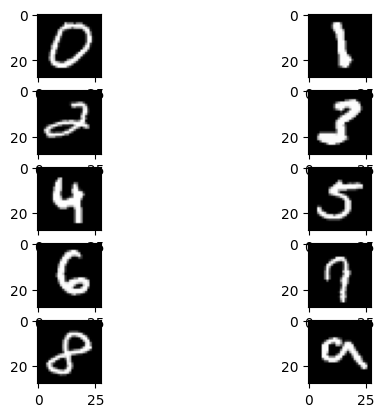

In [ ]:
for i in range(10):

    plt.subplot(5,2,i+1)
    image = train_example[train_target==i][0]
    image = image.view(28,28).detach().numpy()
    plt.imshow(image,cmap='gray')

In [ ]:
class_counts = torch.zeros(10)
for data in mnist_train:
    _, label = data
    class_counts[label] += 1

<BarContainer object of 10 artists>

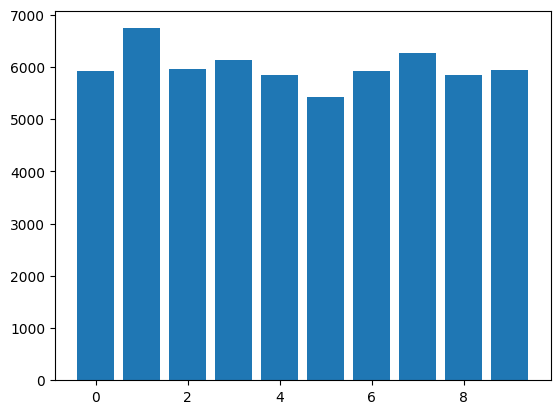

In [ ]:
classes = list(range(10))
plt.bar(classes, class_counts)

### Teacher

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher,self).__init__()
        self.layer1 = nn.Linear(28*28,1024)
        self.layer2 = nn.Linear(1024,512)
        self.layer3 = nn.Linear(512,10)

    def forward(self,x):
        x = x.view(-1,28*28)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [ ]:
teacher_model = Teacher().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_model.parameters(), lr=0.01)

In [ ]:
epochs = 20
Loss = []
for epoch in range(epochs):

    for i, (input,target) in enumerate(train_data):

        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        yhat = teacher_model(input)
        loss = criterion(yhat,target)
        loss.backward()
        optimizer.step()
    print(epoch)
    Loss.append(loss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
# Evaluate the model with test data

device(type='cuda')